In [1]:
# import tensorflow as tf
import cv2
import sys
import os
import glob
# import Misc.ImageUtils as iu
import random
import matplotlib.pyplot as plt
import numpy as np
import time
import argparse
from StringIO import StringIO
import string
import math as m
from tqdm import tqdm
import dlib
from imutils import face_utils

In [2]:
# Check if a point is inside a rectangle
def rect_contains(rect, point) :
    if point[0] < rect[0] :
        return False
    elif point[1] < rect[1] :
        return False
    elif point[0] > rect[2] :
        return False
    elif point[1] > rect[3] :
        return False
    return True
 
# Draw a point
def draw_point(img, p, color ) :
    cv2.circle( img, p, 2, color, 0 )
 
 
# Draw delaunay triangles
def draw_delaunay(img, subdiv, delaunay_color ) :
 
    triangleList = subdiv.getTriangleList();
    #print(triangleList)

    size = img.shape
    r = (0, 0, size[1], size[0])
 
    for t in triangleList :
         
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])
         
        if rect_contains(r, pt1) and rect_contains(r, pt2) and rect_contains(r, pt3) :
         
            cv2.line(img, pt1, pt2, delaunay_color, 1, cv2.LINE_AA, 0)
            cv2.line(img, pt2, pt3, delaunay_color, 1, cv2.LINE_AA, 0)
            cv2.line(img, pt3, pt1, delaunay_color, 1, cv2.LINE_AA, 0)
 

In [3]:
# Draw delaunay triangles
def getTriMatches(r,subdiv,indexDict,firstPoints,secondPoints) :
    pointsArray=[(0,0),(0,0),(0,0)]
    
    firstTriangles=[]
    secTriangles=[]
    triangleList = subdiv.getTriangleList();
   # print(triangleList)
    for t in triangleList :
         
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])
        
        
                 
            
        if rect_contains(r, pt1) and rect_contains(r, pt2) and rect_contains(r, pt3) :
            first=indexDict[pt1]
            second=indexDict[pt2]
            third=indexDict[pt3]

            ptI11 = (firstPoints[first][0], firstPoints[first][1])
            ptI12 = (firstPoints[second][0], firstPoints[second][1])
            ptI13 = (firstPoints[third][0], firstPoints[third][1])

            ptI21 = (secondPoints[first][0], secondPoints[first][1])
            ptI22 = (secondPoints[second][0], secondPoints[second][1])
            ptI23 = (secondPoints[third][0], secondPoints[third][1])
                #print('lol1')
            tempFirst=[ptI11,ptI12,ptI13]
            tempSecond=[ptI21,ptI22,ptI23]
            
            
#             firstTriangles=np.vstack((firstTriangles,tempFirst))
            firstTriangles.append(tempFirst)
            
#             print(firstTriangles)
            secTriangles.append(tempSecond)

#             secTriangles=np.vstack((secTriangles,tempSecond))
    #print(firstTriangles)
    #np.delete(firstTriangles,0)
    #np.delete(secTriangles,0)

    return np.asarray(firstTriangles),np.asarray(secTriangles)

In [4]:

def getPoints(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)
#     print('rects')
#     print(rects)
    points=0
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        shape = predictor(img, rect)
        shape = face_utils.shape_to_np(shape)
        points=shape
    return points


In [5]:

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/home/abhinav/CMSC-733/Abhi1625_p2/shape_predictor.dat')
# predictor = dlib.shape_predictor('/home/kartikmadhira/Semester 2/CMSC733/project2/shape_predictor_68_face_landmarks.dat')
# Define window names
# Define colors for drawing.
delaunay_color = (255,255,255)

points_color = (0, 0, 255)

# Read in the image.
firstImage =  cv2.imread('/home/abhinav/CMSC-733/Abhi1625_p2/prateek.jpeg')
img =  cv2.imread('/home/kartikmadhira/Semester 2/CMSC733/project2/ozil.jpeg')
secondImage=cv2.imread('/home/abhinav/CMSC-733/Abhi1625_p2/kartik.jpg')

In [6]:
# firstImageSize = np.shape(firstImage)
# secondImageSize = np.shape(secondImage)
# print(firstImageSize)
# print(secondImageSize)
firstImage = cv2.resize(firstImage,(200,200))
secondImage = cv2.resize(secondImage,(200,200))
# reshape_size = np.minimum(firstImageSize[1],secondImageSize[1])
# print(tuple(reshape_size))
# print(reshape_size)
# if(reshape_size is np.shape(firstImage)):
#     secondImage = cv2.resize(secondImage,tuple(reshape_size[:2]))
#     print('nitin reshaped')
# else:
#     firstImage = cv2.resize(firstImage,tuple(reshape_size[:2]))
#     print('chahat reshaped')

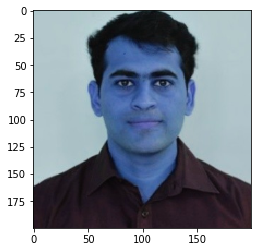

In [7]:
plt.imshow(firstImage)

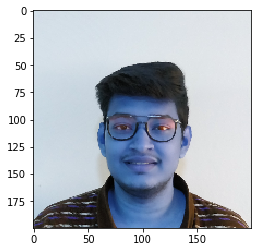

In [8]:
plt.imshow(secondImage)

In [9]:
# secondImage = cv2.resize(secondImage,(200,200))
secondImage = cv2.cvtColor(secondImage,cv2.COLOR_BGR2RGB)
firstImage = cv2.cvtColor(firstImage,cv2.COLOR_BGR2RGB)


In [10]:
#create copy of the first image

#get the sizes of the images
firstSize=firstImage.shape
firstRect= (0, 0, firstSize[1], firstSize[0])

secondSize=secondImage.shape
secondRect= (0, 0, secondSize[1], secondSize[0])
canvasRect=(0,0,firstSize[1]+secondSize[1],firstSize[0]+secondSize[0])


#create instances of subdiv
firstSubdiv = cv2.Subdiv2D(firstRect);
secondSubdiv = cv2.Subdiv2D(secondRect);
canvasSubdiv=cv2.Subdiv2D(canvasRect);


#get the facial markers from the images.
firstArray=getPoints(firstImage)
secondArray=getPoints(secondImage)


In [11]:


def get_face_params(img,feature_points, allowance=10):
#   input---
#   img: input image
#   feature_points: numpy array of feature points from dlib predictor 
#   allowance: extra region to house face in a rectangle

#   output---
#   cropped face
#   shifted feature points w.r.t cropped face
#   height and width of cropped image

    im_w, im_h = img.shape[:2]
    # finding leftmost point in the image
    print(feature_points)
    left, top = np.min(feature_points.astype(np.uint8), 0)
    if left<top:
        top = left
    else:
        left = top
    # finding bottom right point in the image
    right, bottom = np.max(feature_points.astype(np.uint8), 0)
    if right>bottom:
        bottom = right
    else:
        right = bottom
    
    x, y = max(0, left-allowance), max(0, top-allowance)
    w, h = min(right+allowance, im_h)-x, min(bottom+allowance, im_w)-y
    new_points = feature_points - np.asarray([[x, y]])
    rect = (x, y, w, h)
    cropped_img = img[y:y+h, x:x+w]
    return new_points, rect, cropped_img

firstArray, src_shape, src_face = get_face_params(firstImage.copy(), firstArray)
secondArray, dst_shape, dst_face = get_face_params(secondImage.copy(), secondArray)

firstCopy=src_face.copy()
secondCopy=dst_face.copy()

[[ 60  71]
 [ 61  81]
 [ 63  91]
 [ 65 101]
 [ 68 110]
 [ 73 118]
 [ 81 125]
 [ 91 130]
 [102 131]
 [113 130]
 [122 124]
 [130 118]
 [135 110]
 [137 100]
 [139  91]
 [140  81]
 [141  70]
 [ 68  62]
 [ 73  56]
 [ 81  54]
 [ 89  55]
 [ 96  58]
 [106  58]
 [113  55]
 [121  54]
 [128  56]
 [133  62]
 [102  65]
 [102  72]
 [102  78]
 [102  85]
 [ 93  90]
 [ 98  91]
 [102  93]
 [106  91]
 [110  89]
 [ 77  68]
 [ 82  64]
 [ 87  65]
 [ 92  69]
 [ 87  70]
 [ 81  70]
 [111  68]
 [116  64]
 [121  64]
 [126  68]
 [122  70]
 [116  70]
 [ 86 103]
 [ 92 101]
 [ 98  99]
 [102 100]
 [106  99]
 [112 100]
 [118 102]
 [112 106]
 [107 108]
 [102 109]
 [ 98 108]
 [ 92 107]
 [ 88 104]
 [ 98 103]
 [102 104]
 [107 103]
 [116 103]
 [107 103]
 [102 103]
 [ 98 103]]
[[ 65 113]
 [ 65 121]
 [ 66 130]
 [ 67 138]
 [ 69 146]
 [ 74 153]
 [ 80 159]
 [ 88 163]
 [ 99 165]
 [108 164]
 [117 160]
 [125 154]
 [130 147]
 [133 139]
 [135 130]
 [136 120]
 [137 111]
 [ 67 102]
 [ 71  95]
 [ 78  94]
 [ 85  94]
 [ 93  97]
 [103  97

In [12]:
src_shape

(44, 44, 107, 107)

In [13]:

#get the average of the points
averagePoints=(firstArray+secondArray)/2


points=[]
for i in range(0,68):
    points.append((averagePoints[i][0],averagePoints[i][1],))


#create a dict for points to index      
indexDict={}
i=0
for p in points:
    indexDict[p]=i
    i+=1
#indexDict[(238.0, 244.0)]
    
#add points to the subdiv instances
for p in points :
    #print(p)
    canvasSubdiv.insert(p)
firstTriangle,secondTriangle=getTriMatches(canvasRect,canvasSubdiv,indexDict,firstArray,secondArray)


In [14]:
# Draw delaunay triangles
def drawSingle(img, pts, delaunay_color ) :
 
    #print(triangleList)

    size = img.shape
    r = (0, 0, size[1], size[0])
 
    
        
    pt1 = tuple(pts[9][0])
    pt2 = tuple(pts[9][1])
    pt3 = tuple(pts[9][2])

    if rect_contains(r, pt1) and rect_contains(r, pt2) and rect_contains(r, pt3) :

        cv2.line(img, pt1, pt2, delaunay_color, 1, cv2.LINE_AA, 0)
        cv2.line(img, pt2, pt3, delaunay_color, 1, cv2.LINE_AA, 0)
        cv2.line(img, pt3, pt1, delaunay_color, 1, cv2.LINE_AA, 0)
    plt.imshow(img)
 

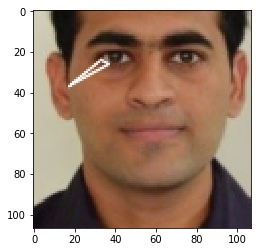

In [15]:
drawSingle(firstCopy.copy(),firstTriangle,(255,255,255))

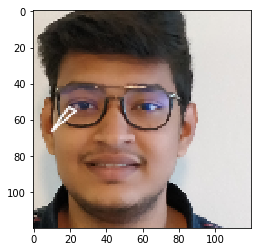

In [16]:
drawSingle(secondCopy.copy(),secondTriangle,(255,255,255))

In [17]:
secondTriangle

array([[[ 38,  42],
        [ 28,  51],
        [ 30,  39]],

       [[ 28,  51],
        [ 38,  42],
        [ 33,  54]],

       [[ 53,  90],
        [ 70,  99],
        [ 62, 105]],

       [[ 70,  99],
        [ 53,  90],
        [ 58,  85]],

       [[ 12,  83],
        [ 10,  66],
        [ 11,  75]],

       [[ 10,  66],
        [ 10,  58],
        [ 19,  53]],

       [[ 43,  64],
        [ 34,  73],
        [ 33,  54]],

       [[ 34,  73],
        [ 43,  64],
        [ 43,  71]],

       [[ 11,  75],
        [ 10,  66],
        [ 23,  55]],

       [[ 10,  66],
        [ 19,  53],
        [ 23,  55]],

       [[ 12,  83],
        [ 11,  75],
        [ 26,  84]],

       [[ 53,  82],
        [ 52,  74],
        [ 60,  84]],

       [[ 52,  74],
        [ 53,  82],
        [ 48,  75]],

       [[ 14,  91],
        [ 12,  83],
        [ 26,  84]],

       [[ 33,  82],
        [ 38,  75],
        [ 38,  81]],

       [[ 38,  75],
        [ 33,  82],
        [ 34,  73]],

       [

In [18]:
dstImage=secondCopy.copy()

In [19]:
shape=dstImage.shape
xmin=0
ymin=0
xmax=shape[0]
ymax=shape[1]
xmin,ymin,xmax,ymax

(0, 0, 120, 120)

In [20]:
X, Y = np.mgrid[xmin:xmax, ymin:ymax]
locations=np.vstack((X.ravel(), Y.ravel()))
print(locations)
locations=np.vstack((locations,np.ones(shape=(1,ymax*ymax))))

[[  0   0   0 ... 119 119 119]
 [  0   1   2 ... 117 118 119]]


In [21]:
locations[2]

array([1., 1., 1., ..., 1., 1., 1.])

In [22]:
# firstTriangle[0][1][0]
secondTriangle[6]

array([[43, 64],
       [34, 73],
       [33, 54]])

In [23]:
def calcBaryCentres(dstImg,srcImg,firstTriangle,secondTriangle):
#     secondImage=dstImg.copy()
    rows, cols = np.shape(dstImg)[:2]
    print(rows)
    print(cols)
    secondImage = np.zeros((rows, cols, 3), dtype=int)
    firstCopy=srcImg.copy()
    shape=dstImg.shape
    xmin=0
    ymin=0
    xmax=shape[0]
    ymax=shape[1]
    X, Y = np.mgrid[xmin:xmax, ymin:ymax]
    locations=np.vstack((X.ravel(), Y.ravel()))
    locations=np.vstack((locations,np.ones(shape=(1,ymax*ymax))))
    for i,_ in enumerate(firstTriangle):  
        #getting BDelta function
        bDelta=[[secondTriangle[i][0][0],secondTriangle[i][0][1],1],
        [secondTriangle[i][1][0],secondTriangle[i][1][1],1],
       [secondTriangle[i][2][0],secondTriangle[i][2][1],1]]
        #transposing to get the proper format
        bDelta=np.matrix(bDelta).transpose()
#         print(bDelta)
        #calculate barycentres and then filter
        try:
            inverse = np.linalg.inv(bDelta)
        except np.linalg.LinAlgError:
            # Not invertible. Skip this one.
            pass
        else:
    # continue with what you were doing
        
        
            baryCentres=np.matmul(np.linalg.inv(bDelta),locations)

            #threshold 
            check=np.where((baryCentres[0]>=0)&(baryCentres[0]<=1)
                           &(baryCentres[1]>=0)&(baryCentres[1]<=1)
                           &(baryCentres[2]>=0)&(baryCentres[2]<=1))
            #access correspoinding pixels that follow the barycentric constraints
            pts_dest = locations[:2,check[1]]

            aDelta=[[firstTriangle[i][0][0],firstTriangle[i][0][1],1],
            [firstTriangle[i][1][0],firstTriangle[i][1][1],1],
           [firstTriangle[i][2][0],firstTriangle[i][2][1],1]]

            #transposing to get the proper format
            aDelta=np.matrix(aDelta).transpose()

            threshBaryCentres=baryCentres[:,check[1]]

            #calculate barycentres and then filter
            newCentres=np.matmul(aDelta,threshBaryCentres)

            #newCentres=np.divide(newCentres,newCentres[2])

            firstImageValues=firstCopy[newCentres[1].astype(int),newCentres[0].astype(int)]
            
            secondImage[pts_dest[1].astype(int),pts_dest[0].astype(int)]=firstImageValues
        
    return secondImage
    

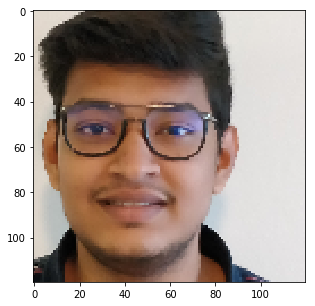

In [56]:
plt.imshow(secondCopy)

120
120


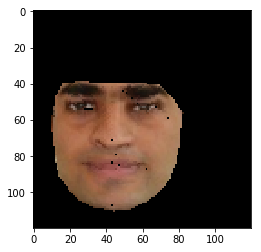

In [24]:
warped_src_face = calcBaryCentres(secondCopy.copy(),firstCopy.copy(),firstTriangle,secondTriangle)
plt.imshow(warped_src_face)

In [25]:
def mask_from_points(size, points,erode_flag=1):
    radius = 10  # kernel size
    kernel = np.ones((radius, radius), np.uint8)

    mask = np.zeros(size, np.uint8)
    cv2.fillConvexPoly(mask, cv2.convexHull(points), 255)
    if erode_flag:
        mask = cv2.erode(mask, kernel,iterations=1)

    return mask

In [26]:
## Copy-and-paste
def apply_mask(img, mask):
    """ Apply mask to supplied image
    :param img: max 3 channel image
    :param mask: [0-255] values in mask
    :returns: new image with mask applied
    """
    masked_img=cv2.bitwise_and(img,img,mask=mask)

    return masked_img

In [27]:
def correct_colours(im1, im2, landmarks1):
    COLOUR_CORRECT_BLUR_FRAC = 0.75
    LEFT_EYE_POINTS = list(range(42, 48))
    RIGHT_EYE_POINTS = list(range(36, 42))

    blur_amount = COLOUR_CORRECT_BLUR_FRAC * np.linalg.norm(
                              np.mean(landmarks1[LEFT_EYE_POINTS], axis=0) -
                              np.mean(landmarks1[RIGHT_EYE_POINTS], axis=0))
    blur_amount = int(blur_amount)
    if blur_amount % 2 == 0:
        blur_amount -= 1
    im1_blur = cv2.GaussianBlur(im1, (blur_amount, blur_amount), 0)
    im2_blur = cv2.GaussianBlur(im2, (blur_amount, blur_amount), 0)
#     im2_blur = im2

    # Avoid divide-by-zero errors.
    im2_blur = im2_blur.astype(int)
    im2_blur += 128*(im2_blur <= 1)

    result = im2.astype(np.float64) * im1_blur.astype(np.float64) / im2_blur.astype(np.float64)
    result = np.clip(result, 0, 255).astype(np.uint8)

    return result

In [28]:
plt.rcParams["figure.figsize"] = (5,5)

w, h = dst_face.shape[:2]
## Mask for blending
mask = mask_from_points((w, h), secondArray)
# plt.imshow(mask)
mask_src = np.mean(warped_src_face, axis=2) > 0
mask = np.asarray(mask*mask_src, dtype=np.uint8)
# plt.imshow(warped_src_face)
## Correct color
# if not args.warp_2d and args.correct_color:
warped_src_face = apply_mask(warped_src_face, mask.copy())
dst_face_masked = apply_mask(dst_face, mask.copy())
warped_src_face = warped_src_face.astype(np.uint8)
# np.asarray(warped_src_face,dtype=np.uint8)
print(warped_src_face.dtype)
warped_src_face = correct_colours(dst_face_masked, warped_src_face, secondArray)
# plt.imshow(warped_src_face)

uint8


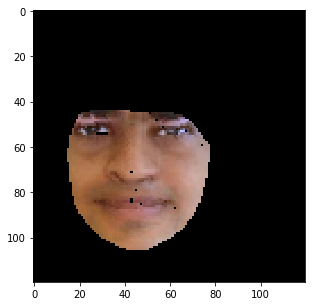

In [29]:
plt.imshow(warped_src_face)

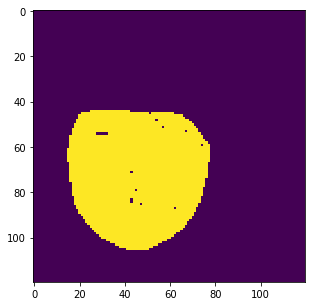

In [30]:
plt.imshow(mask)

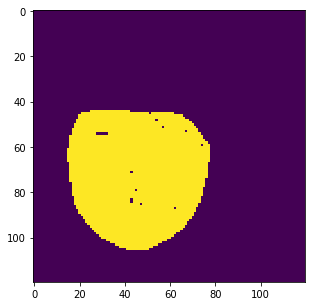

In [31]:
# kernel = np.ones((3, 3), np.uint8)
# mask = cv2.erode(mask, kernel, iterations=1)
# mask = cv2.dilate(mask, kernel, iterations=1)

plt.imshow(mask)
##Poisson Blending
r = cv2.boundingRect(mask)
center = ((r[0] + int(r[2] / 2), r[1] + int(r[3] / 2)))
output = cv2.seamlessClone(warped_src_face, dst_face, mask, center, cv2.NORMAL_CLONE)

x, y, w, h = dst_shape
dst_img_cp = secondImage.copy()
dst_img_cp[y:y+h, x:x+w] = output
output = dst_img_cp

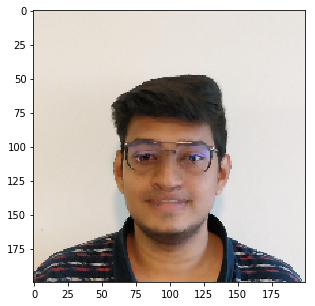

In [32]:
plt.imshow(output)

In [33]:
bDelta=[[secondTriangle[12][0][0],secondTriangle[12][0][1],1],
        [secondTriangle[12][1][0],secondTriangle[12][1][1],1],
       [secondTriangle[12][2][0],secondTriangle[12][2][1],1]]

In [34]:
bDelta

[[52, 74, 1], [53, 82, 1], [48, 75, 1]]

In [35]:
bDelta=np.matrix(bDelta).transpose()
baryCentres=np.matmul(np.linalg.inv(bDelta),locations)

In [36]:
bDelta

matrix([[52, 53, 48],
        [74, 82, 75],
        [ 1,  1,  1]])

In [37]:
baryCentres.shape

(3, 14400)

In [38]:
check=np.where((baryCentres[0]>=0)&(baryCentres[0]<=1)&(baryCentres[1]>=0)&(baryCentres[1]<=1)&(baryCentres[2]>=0)&(baryCentres[2]<=1))
#                &(np.sum(baryCentres,axis=0)==1))
check

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([5955, 5956, 6075, 6076, 6077, 6195, 6196, 6197, 6198, 6199, 6314,
        6315, 6316, 6317, 6318, 6319, 6320]))

In [39]:
check[1]
np.shape(check)

(2, 17)

In [40]:
baryCentres[:,check[1]].shape

(3, 17)

In [41]:
pts_dest = locations[:2,check[1]]


In [42]:
pts_dest.shape

(2, 17)

In [43]:
pts_dest = np.asarray(pts_dest,dtype=int)
pts_dest.shape

(2, 17)

In [44]:
def plot_bary_correspond_dest(dest_img, pts):
    img = dest_img.copy()
    for i,_ in enumerate(pts):
        img[pts[1],pts[0],:] = [255,0,0]
    plt.imshow(img)

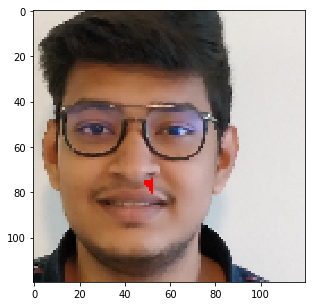

In [45]:
plot_bary_correspond_dest(secondCopy,pts_dest)


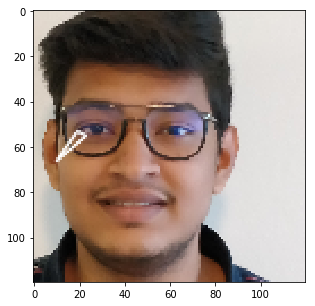

In [46]:
drawSingle(secondCopy.copy(),secondTriangle,(255,255,255))

In [47]:
aDelta=[[firstTriangle[12][0][0],firstTriangle[12][0][1],1],
        [firstTriangle[12][1][0],firstTriangle[12][1][1],1],
       [firstTriangle[12][2][0],firstTriangle[12][2][1],1]]

In [48]:
#transposing to get the proper format
aDelta=np.matrix(aDelta).transpose()

threshBaryCentres=baryCentres[:,check[1]]

#calculate barycentres and then filter
newCentres=np.matmul(aDelta,threshBaryCentres)

newCentres=np.divide(newCentres,newCentres[2])







In [49]:
firstImageValues=firstCopy[newCentres[1].astype(int),newCentres[0].astype(int)]

In [50]:
secondImage[pts_dest[1],pts_dest[0]]=firstImageValues

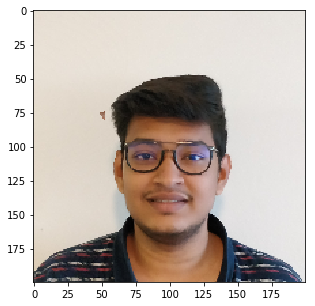

In [51]:
plt.imshow(secondImage)

In [52]:
import scipy.interpolate

In [53]:
new=scipy.interpolate.interp2d(newCentres[0],newCentres[1],newCentres[2])

/usr/lib/python2.7/dist-packages/scipy/interpolate/fitpack.py:975: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=6,7 m=17 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [54]:
def bilinear_interpolate(img, coords):
    """ Interpolates over every image channel
    http://en.wikipedia.org/wiki/Bilinear_interpolation
    :param img: max 3 channel image
    :param coords: 2 x _m_ array. 1st row = xcoords, 2nd row = ycoords
    :returns: array of interpolated pixels with same shape as coords
    """
    int_coords = np.int32(coords)
    x0, y0 = int_coords
    dx, dy = coords - int_coords

    # 4 Neighour pixels
    q11 = img[y0, x0]
    q21 = img[y0, x0 + 1]
    q12 = img[y0 + 1, x0]
    q22 = img[y0 + 1, x0 + 1]

    btm = q21.T * dx + q11.T * (1 - dx)
    top = q22.T * dx + q12.T * (1 - dx)
    inter_pixel = top * dy + btm * (1 - dy)

    return inter_pixel.T


In [55]:
b=bilinear_interpolate(firstCopy.copy(),newCentres[0:2])

ValueError: shape too large to be a matrix.